# First Model training (aligned with baseline)

Use the same numeric features and metrics as the logistic regression baseline for apples-to-apples comparison.

## Setup and imports

In [203]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


## Data loading and splits (stratified 60/20/20)

In [204]:
CAT_COLS = [
    "driver_id",
    "constructor_id",
    "circuit_id",
]
NUM_COLS = [
    "grid_position",
    "quali_delta",
    "quali_tm_delta",
    "season_pts_driver",
    "season_pts_team",
    "last_3_avg",
    "is_street_circuit",
    "is_wet",
]
FEATURES = CAT_COLS + NUM_COLS
TARGET = "points_scored"



train_df = pd.read_csv("data/grandprix_features_train.csv")
val_df   = pd.read_csv("data/grandprix_features_val.csv") 
test_df  = pd.read_csv("data/grandprix_features_test.csv")

X_train, y_train = train_df[CAT_COLS + NUM_COLS], train_df[TARGET]
X_val,   y_val   = val_df[CAT_COLS + NUM_COLS],   val_df[TARGET]
X_test,  y_test  = test_df[CAT_COLS + NUM_COLS],  test_df[TARGET]
print(f"Splits -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


Splits -> train: 2960, val: 740, test: 926


## Preprocessing (impute + standardize numeric)

In [205]:
import pandas as pd

cat_cols = ["driver_id", "constructor_id", "circuit_id"]
id_maps = {}
for col in cat_cols:
    uniques = pd.concat([train_df[col], val_df[col], test_df[col]]).unique()
    id_maps[col] = {v: i for i, v in enumerate(sorted(uniques))}
    unk_idx = len(id_maps[col])
    id_maps[col]["__unk__"] = unk_idx

def encode_cats(df, col):
    m = id_maps[col]
    unk = m["__unk__"]
    return df[col].map(m).fillna(unk).astype(int)

num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
num_pipeline.fit(train_df[NUM_COLS])

def make_tensors(df):
    cat_tensors = [torch.tensor(encode_cats(df, c).values, dtype=torch.long) for c in cat_cols]
    num_tensor = torch.tensor(num_pipeline.transform(df[NUM_COLS]), dtype=torch.float32)
    return cat_tensors, num_tensor

train_cats, train_nums = make_tensors(train_df)
val_cats,   val_nums   = make_tensors(val_df)
test_cats,  test_nums  = make_tensors(test_df)

y_train = train_df[TARGET].values.astype(np.float32)
y_val = val_df[TARGET].values.astype(np.float32)
y_test = test_df[TARGET].values.astype(np.float32)

# Class weighting for imbalance (matches logistic regression class_weight="balanced")
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
pos_weight = torch.tensor(neg / pos, dtype=torch.float32)
print(f"pos_weight: {pos_weight:.3f}")


pos_weight: 1.029


## Dataset and DataLoader

In [206]:
class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, cats, nums, y):
        self.cats = [c for c in cats]
        self.nums = nums
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [c[idx] for c in self.cats], self.nums[idx], self.y[idx]

train_ds = MixedDataset(train_cats, train_nums, train_df[TARGET])
val_ds = MixedDataset(val_cats, val_nums, val_df[TARGET])
test_ds = MixedDataset(test_cats, test_nums, test_df[TARGET])

batch_size = 32
generator = torch.Generator().manual_seed(42)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


## Model

In [ ]:
cat_dims = [len(id_maps[c]) for c in cat_cols]
embed_dims = [min(50, (n + 1) // 2) for n in cat_dims]
num_dim = len(NUM_COLS)

class EmbeddedPointsMLP(nn.Module):
    def __init__(self, cat_dims, embed_dims, num_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(n, d) for n, d in
zip(cat_dims, embed_dims)])
        cat_out_dim = sum(embed_dims)
        hidden_in = cat_out_dim + num_dim
        self.mlp = nn.Sequential(
            nn.Linear(hidden_in, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
        )

    def forward(self, cat_inputs, num_inputs):
        # cat_inputs: list of (batch,)
        embeds = [emb(x) for emb, x in zip(self.embeddings, cat_inputs)]
        cat_feat = torch.cat(embeds, dim=1)
        x = torch.cat([cat_feat, num_inputs], dim=1)
        return self.mlp(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddedPointsMLP(cat_dims=cat_dims, embed_dims=embed_dims, num_dim=num_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
print('Using device:', device)


Using device: cpu


## Training and evaluation helpers

In [208]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for cat_batch, num_batch, y_batch in dataloader:
        cat_batch = [c.to(device) for c in cat_batch]
        num_batch = num_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        logits = model(cat_batch, num_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_samples += y_batch.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for cat_batch, num_batch, y_batch in dataloader:
            cat_batch = [c.to(device) for c in cat_batch]
            num_batch = num_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            logits = model(cat_batch, num_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_samples += y_batch.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def collect_predictions(model, dataloader, device):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for cat_batch, num_batch, y_batch in dataloader:
            cat_batch = [c.to(device) for c in cat_batch]
            num_batch = num_batch.to(device)
            logits = model(cat_batch, num_batch)
            probs = torch.sigmoid(logits).squeeze(1)

            all_probs.append(probs.cpu())
            all_targets.append(y_batch)

    probs = torch.cat(all_probs)
    targets = torch.cat(all_targets)
    preds = (probs >= 0.5).float()
    return targets, probs, preds


## Train loop

In [209]:
torch.manual_seed(42)
np.random.seed(42)

num_epochs = 50
patience = 5  # stop if no val loss improvement for these many epochs
min_delta = 1e-4

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

best_val_loss = float('inf')
best_state = None
best_epoch = 0
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.3f}"
    )

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(
            f"Early stopping at epoch {epoch} | "
            f"Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch}"
        )
        break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model from epoch {best_epoch} (val loss {best_val_loss:.4f})")


Epoch 01 | Train Loss: 0.6134  Acc: 0.704 | Val Loss: 0.5118  Acc: 0.773
Epoch 02 | Train Loss: 0.5018  Acc: 0.771 | Val Loss: 0.4715  Acc: 0.792
Epoch 03 | Train Loss: 0.4796  Acc: 0.786 | Val Loss: 0.4625  Acc: 0.795
Epoch 04 | Train Loss: 0.4673  Acc: 0.786 | Val Loss: 0.4570  Acc: 0.796
Epoch 05 | Train Loss: 0.4600  Acc: 0.799 | Val Loss: 0.4523  Acc: 0.793
Epoch 06 | Train Loss: 0.4507  Acc: 0.799 | Val Loss: 0.4529  Acc: 0.789
Epoch 07 | Train Loss: 0.4429  Acc: 0.802 | Val Loss: 0.4570  Acc: 0.795
Epoch 08 | Train Loss: 0.4353  Acc: 0.807 | Val Loss: 0.4618  Acc: 0.792
Epoch 09 | Train Loss: 0.4313  Acc: 0.808 | Val Loss: 0.4649  Acc: 0.785
Epoch 10 | Train Loss: 0.4236  Acc: 0.813 | Val Loss: 0.4637  Acc: 0.786
Early stopping at epoch 10 | Best Val Loss: 0.4523 at epoch 5
Loaded best model from epoch 5 (val loss 0.4523)


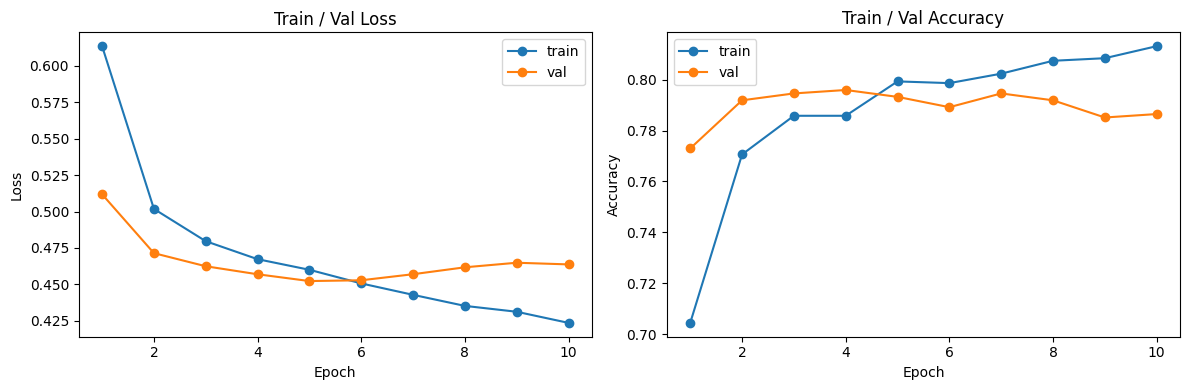

In [210]:
plt.figure(figsize=(12, 4))
epochs_ran = range(1, len(train_loss_hist) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_loss_hist, marker="o", label="train")
plt.plot(epochs_ran, val_loss_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_acc_hist, marker="o", label="train")
plt.plot(epochs_ran, val_acc_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Test set evaluation (same metrics as baseline)

In [211]:
# Loss/accuracy
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

# Probabilities and class metrics
test_targets, test_probs, test_preds = collect_predictions(model, test_loader, device)

test_targets_np = test_targets.numpy()
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()


print('Precision:', precision_score(test_targets_np, test_preds_np))
print('Recall:', recall_score(test_targets_np, test_preds_np))
print('F1 (binary):', f1_score(test_targets_np, test_preds_np))
print('F1 (macro):', f1_score(test_targets_np, test_preds_np, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(test_targets_np, test_preds_np))

Precision: 0.7641921397379913
Recall: 0.7675438596491229
F1 (binary): 0.7658643326039387
F1 (macro): 0.7688596716324598
Balanced accuracy: 0.7688783128032848


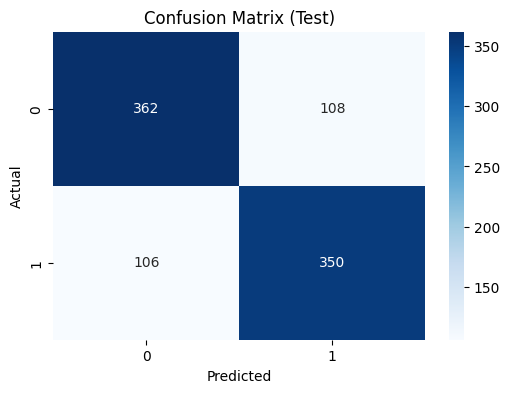

In [212]:
import seaborn as sns
cm = confusion_matrix(test_targets_np, test_preds_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
